## Лабораторная работа №7 
###  По предмету "методы, средства и технологии мультимедиа"
#### Выполнил: Стрыгин Д.Д. 
#### Группа: М8О-406Б-19

In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import os
import sklearn
import time
import copy
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/datasets/'
train_path, val_path = [], []
with open(PATH + 'train_lst.txt', 'r') as f:
    for line in f:
      train_path += [PATH + line.split(' ')[0]]
with open(PATH + 'val_lst.txt', 'r') as f:
    for line in f:
      val_path += [PATH + line.split(' ')[0]]

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        image = Image.open(file_path)
        lbl = file_path.split('/')[6]
        if self.transform:
            image = self.transform(image)
        return image, lbl

In [ ]:
seed = 42
gen = torch.Generator().manual_seed(seed)

In [ ]:
batch_size = 64
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 
trainset = MyDataset(train_path, data_transforms['train'])
testset = MyDataset(val_path, data_transforms['test'])
image_datasets = {'train' : trainset, 'test' : testset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4) 
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = datasets.ImageFolder(PATH + '256_ObjectCategories').classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainloader = dataloaders['train']
testloader = dataloaders['test']

## 1 часть (Resnet из pytorch)

In [ ]:
resNet = torchvision.models.resnet18(weights = None)

num_ftrs = resNet.fc.in_features
resNet.fc = torch.nn.Linear(num_ftrs, 257)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adadelta(resNet.parameters(), lr=0.8, weight_decay = 0)

In [ ]:
resNet = resNet.to(device)

In [ ]:
def test(model, testloader,criterion, verbal = True, rec_loss = False):
    was_training = copy.deepcopy(model.training)
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    if(verbal):
        iterator = tqdm(testloader)
    else:
        iterator = testloader
        
    for inputs, labels in iterator:
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        with torch.no_grad():
            
            outputs = model(inputs)
            
        pred = torch.argmax(outputs, dim = 1)
        
        loss = criterion(outputs, labels)
                
        running_loss += loss.cpu().detach().numpy()
        running_corrects += torch.sum(pred == labels).cpu().detach().numpy()
        
    ovl_loss = running_loss / (len(testloader)*batch_size)
    ovl_acc = float(running_corrects) / (len(testloader)*batch_size)

    if(verbal):
        print('test | loss function val: {} accuracy: {}'.format(ovl_loss, ovl_acc))
    
    if(was_training):
        model.train()
        
    if(rec_loss):
        return ovl_acc, ovl_loss
    return ovl_acc

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler = None, num_epochs=25, verbal = True):
    model.train()
    
    tracing = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    if(verbal):
        iterator_1 = range(num_epochs)
    else:
        iterator_1 = tqdm(range(num_epochs))
            
    train_accurcy, train_loss = test(model, trainloader, criterion, verbal = verbal, rec_loss = True)
    validation_accurcy = test(model, valloader, criterion, verbal = verbal)
    tracing.append([-1, train_loss, train_accurcy, validation_accurcy])
    
    for epoch in iterator_1:
        torch.cuda.empty_cache()

        running_loss = 0.0
        running_corrects = 0
        
        if(verbal):
            iterator = tqdm(trainloader)
        else:
            iterator = trainloader
            
        for inputs, labels in iterator:            
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            pred = torch.argmax(outputs, dim = 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            running_corrects += torch.sum(pred == labels).cpu().detach().numpy()
            

        epoch_loss = running_loss / (len(trainloader) * batch_size)
        epoch_acc = float(running_corrects) / (len(trainloader)*batch_size)
        
        if(scheduler):
            scheduler.step() 

        if(verbal):
            print('epoch {} | loss function val: {} accuracy: {}'.format(epoch, epoch_loss, epoch_acc))

        validation_accurcy = test(model,valloader,criterion, verbal = verbal)
        tracing.append([epoch,epoch_loss,epoch_acc,validation_accurcy])
        
        if validation_accurcy > best_acc:
            del best_model_wts
            torch.cuda.empty_cache()
            best_acc = validation_accurcy
            best_model_wts = copy.deepcopy(model.state_dict())

        if(verbal):
            print()

    time_elapsed = time.time() - since
    
    if(verbal):
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    
    return model, np.array(tracing)

### Обучение готовой модели ResNet

In [ ]:
resNet, tracing = train_model(resNet, trainloader, testloader, criterion, optimizer, num_epochs = 20)

100%|█████████████████████████████████████████| 383/383 [00:40<00:00,  9.52it/s]


test | loss function val: 0.008199163840222842 accuracy: 0.8713283289817232


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.32it/s]


test | loss function val: 0.03495828822876016 accuracy: 0.5948893229166666


100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 0 | loss function val: 0.008882678355219198 accuracy: 0.8626387075718016


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.21it/s]


test | loss function val: 0.036285689003610365 accuracy: 0.5721028645833334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 1 | loss function val: 0.00877334509292914 accuracy: 0.859375


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.27it/s]


test | loss function val: 0.03777774341870099 accuracy: 0.5725911458333334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.37it/s]


epoch 2 | loss function val: 0.008655282499161658 accuracy: 0.8624755221932114


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.28it/s]


test | loss function val: 0.0365805885133644 accuracy: 0.5851236979166666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 3 | loss function val: 0.008564337867971112 accuracy: 0.8626795039164491


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.28it/s]


test | loss function val: 0.035853012542550765 accuracy: 0.5843098958333334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.37it/s]


epoch 4 | loss function val: 0.008660210037540752 accuracy: 0.8632098563968669


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.26it/s]


test | loss function val: 0.03795843004869918 accuracy: 0.5787760416666666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.37it/s]


epoch 5 | loss function val: 0.008624749818048378 accuracy: 0.8614556135770235


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.28it/s]


test | loss function val: 0.03710546975101655 accuracy: 0.5791015625



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 6 | loss function val: 0.008467966183052246 accuracy: 0.8690845300261096


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.05it/s]


test | loss function val: 0.03702174635448804 accuracy: 0.5807291666666666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 7 | loss function val: 0.008416371753770012 accuracy: 0.8692885117493473


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.27it/s]


test | loss function val: 0.03698380716377869 accuracy: 0.57666015625



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 8 | loss function val: 0.008368075620407341 accuracy: 0.8653720626631853


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.29it/s]


test | loss function val: 0.036400039466874055 accuracy: 0.5875651041666666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 9 | loss function val: 0.008322156423474262 accuracy: 0.8682278067885117


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.40it/s]


test | loss function val: 0.037566549280503146 accuracy: 0.5856119791666666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 10 | loss function val: 0.008369886867128137 accuracy: 0.868798955613577


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.32it/s]


test | loss function val: 0.03676295169861987 accuracy: 0.60107421875



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 11 | loss function val: 0.008010933994541709 accuracy: 0.8738577023498695


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.34it/s]


test | loss function val: 0.03575753383726502 accuracy: 0.5930989583333334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 12 | loss function val: 0.007841941635501292 accuracy: 0.8757343342036553


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.32it/s]


test | loss function val: 0.0388614172503973 accuracy: 0.5685221354166666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 13 | loss function val: 0.007910141928058225 accuracy: 0.8773661879895561


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.31it/s]


test | loss function val: 0.037228625073718526 accuracy: 0.5734049479166666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 14 | loss function val: 0.007629710937760206 accuracy: 0.8814458224543081


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.33it/s]


test | loss function val: 0.03580541140399873 accuracy: 0.5927734375



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 15 | loss function val: 0.0078725499744155 accuracy: 0.8769990208877284


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.29it/s]


test | loss function val: 0.03990932024316862 accuracy: 0.5799153645833334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 16 | loss function val: 0.007649517266746056 accuracy: 0.8778965404699739


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.30it/s]


test | loss function val: 0.03871122186925883 accuracy: 0.5826822916666666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 17 | loss function val: 0.007776768856825351 accuracy: 0.8776109660574413


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.33it/s]


test | loss function val: 0.03748939857662966 accuracy: 0.5989583333333334



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.39it/s]


epoch 18 | loss function val: 0.007517217733841341 accuracy: 0.8817313968668408


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.30it/s]


test | loss function val: 0.03612991548531378 accuracy: 0.5880533854166666



100%|█████████████████████████████████████████| 383/383 [01:53<00:00,  3.38it/s]


epoch 19 | loss function val: 0.007488794971011852 accuracy: 0.8817313968668408


100%|███████████████████████████████████████████| 96/96 [00:10<00:00,  9.29it/s]

test | loss function val: 0.03716063965111971 accuracy: 0.5760091145833334

Training complete in 42m 3s
Best val Acc: 0.601074


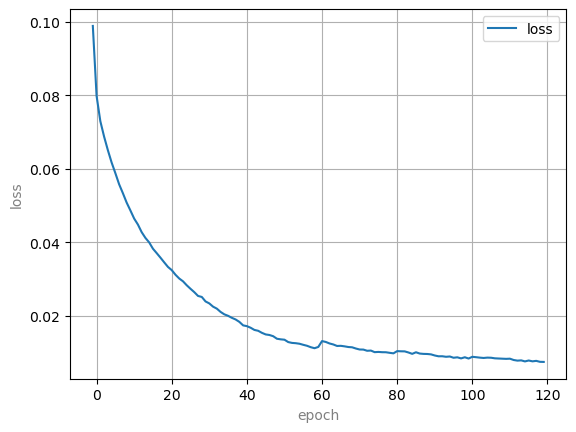

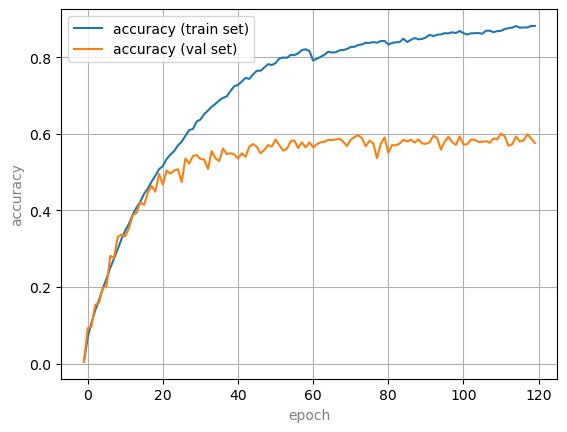

In [ ]:
plt.plot(tracing[:,0], tracing[:,1], label = 'loss')
plt.xlabel("epoch",color = 'b')
plt.ylabel("loss",color = 'y')
plt.legend()
plt.show()
plt.plot(tracing[:,0], tracing[:,2], label = 'accuracy (train set)')
plt.plot(tracing[:,0], tracing[:,3], label = 'accuracy (val set)')
plt.xlabel("epoch", color = 'b')
plt.ylabel("accuracy", color = 'y')
plt.legend()
plt.show()

##### За 120 эпох было достигнуто точность выше, чем 0.6

In [ ]:
torch.save(resNet.state_dict(),'models/torch_resnet18')

In [ ]:
torch.save([trainset,testset],'models/torch_resnet18_datasets')

## Имплементация ResNet

In [ ]:
class Block(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet_18(torch.nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return torch.nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            torch.nn.BatchNorm2d(out_channels)
        )

In [ ]:
my_resnet = ResNet_18(3,257).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adadelta(my_resnet.parameters(), lr=0.8, weight_decay = 0)

### Обучение имплементированной модели ResNet

In [ ]:
my_resnet, tracing = train_model(my_resnet, trainloader, testloader, criterion, optimizer, num_epochs = 40)

100%|█████████████████████████████████████████| 383/383 [00:45<00:00,  8.40it/s]


test | loss function val: 0.010508820133079475 accuracy: 0.832449412532637


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.17it/s]


test | loss function val: 0.0338212990318425 accuracy: 0.583984375


100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.92it/s]


epoch 0 | loss function val: 0.011114079372680141 accuracy: 0.8235966057441253


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.08it/s]


test | loss function val: 0.034181273891590536 accuracy: 0.57666015625



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 1 | loss function val: 0.010939366112441291 accuracy: 0.8236374020887729


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.07it/s]


test | loss function val: 0.0372610820728975 accuracy: 0.5631510416666666



100%|█████████████████████████████████████████| 383/383 [02:12<00:00,  2.90it/s]


epoch 2 | loss function val: 0.010915496613947048 accuracy: 0.8279210182767625


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.05it/s]


test | loss function val: 0.037263626659599446 accuracy: 0.55322265625



100%|█████████████████████████████████████████| 383/383 [02:12<00:00,  2.90it/s]


epoch 3 | loss function val: 0.010683614687687734 accuracy: 0.8315110966057441


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.08it/s]


test | loss function val: 0.035914577407917626 accuracy: 0.5716145833333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 4 | loss function val: 0.010352588242877946 accuracy: 0.8348563968668408


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.12it/s]


test | loss function val: 0.03554474882548675 accuracy: 0.57958984375



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 5 | loss function val: 0.010366580311656387 accuracy: 0.8372633812010444


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.22it/s]


test | loss function val: 0.03703989298082888 accuracy: 0.568359375



100%|█████████████████████████████████████████| 383/383 [02:10<00:00,  2.92it/s]


epoch 6 | loss function val: 0.010133218389811778 accuracy: 0.8381201044386423


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.22it/s]


test | loss function val: 0.03551496937870979 accuracy: 0.5753580729166666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.92it/s]


epoch 7 | loss function val: 0.009867927322149589 accuracy: 0.8459937989556136


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.22it/s]


test | loss function val: 0.03683897435742741 accuracy: 0.58349609375



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.92it/s]


epoch 8 | loss function val: 0.009969368919258446 accuracy: 0.841873368146214


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.20it/s]


test | loss function val: 0.03663490776671097 accuracy: 0.5647786458333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 9 | loss function val: 0.009498574960655861 accuracy: 0.8466465404699739


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.03666899770420665 accuracy: 0.5711263020833334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 10 | loss function val: 0.00965801089595974 accuracy: 0.8485231723237598


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.18it/s]


test | loss function val: 0.03711470088455826 accuracy: 0.5633138020833334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 11 | loss function val: 0.009387852954155432 accuracy: 0.8492575065274152


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.11it/s]


test | loss function val: 0.03693769738310948 accuracy: 0.5712890625



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 12 | loss function val: 0.00918350743090943 accuracy: 0.8554177545691906


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.20it/s]


test | loss function val: 0.03838157960368941 accuracy: 0.5693359375



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 13 | loss function val: 0.009400308304210984 accuracy: 0.8537451044386423


100%|███████████████████████████████████████████| 96/96 [00:12<00:00,  7.98it/s]


test | loss function val: 0.0364661849453114 accuracy: 0.57861328125



100%|█████████████████████████████████████████| 383/383 [02:13<00:00,  2.87it/s]


epoch 14 | loss function val: 0.009192400198556269 accuracy: 0.85411227154047


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.11it/s]


test | loss function val: 0.03850478741029898 accuracy: 0.5540364583333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 15 | loss function val: 0.008856100647274998 accuracy: 0.8613740208877284


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.03837805774916584 accuracy: 0.5595703125



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 16 | loss function val: 0.008787318966874255 accuracy: 0.8615372062663186


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.18it/s]


test | loss function val: 0.03741724977347379 accuracy: 0.5797526041666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 17 | loss function val: 0.009055243164918557 accuracy: 0.8576615535248042


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.12it/s]


test | loss function val: 0.035552083204189934 accuracy: 0.5818684895833334



100%|█████████████████████████████████████████| 383/383 [02:12<00:00,  2.90it/s]


epoch 18 | loss function val: 0.008806763914129247 accuracy: 0.8602317232375979


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.11it/s]


test | loss function val: 0.03855153223654876 accuracy: 0.5667317708333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 19 | loss function val: 0.00870236686908691 accuracy: 0.8630874673629243


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.11it/s]


test | loss function val: 0.03688898203351224 accuracy: 0.5924479166666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 20 | loss function val: 0.008514571635237366 accuracy: 0.8647193211488251


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.10it/s]


test | loss function val: 0.03761226074614873 accuracy: 0.5885416666666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.90it/s]


epoch 21 | loss function val: 0.008212185751734297 accuracy: 0.8701860313315927


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.12it/s]


test | loss function val: 0.0366982960064585 accuracy: 0.5730794270833334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 22 | loss function val: 0.008266048912899983 accuracy: 0.8690845300261096


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.03918682603398338 accuracy: 0.5709635416666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 23 | loss function val: 0.008165205155277999 accuracy: 0.8723074412532638


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.14it/s]


test | loss function val: 0.036766884344009064 accuracy: 0.5859375



100%|█████████████████████████████████████████| 383/383 [02:12<00:00,  2.90it/s]


epoch 24 | loss function val: 0.008299373357140948 accuracy: 0.8714099216710183


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.036487658391706645 accuracy: 0.5877278645833334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 25 | loss function val: 0.00845262284546254 accuracy: 0.8661471932114883


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.13it/s]


test | loss function val: 0.03788017601861308 accuracy: 0.580078125



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 26 | loss function val: 0.008008939502201488 accuracy: 0.8721034595300261


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.16it/s]


test | loss function val: 0.03763422719202936 accuracy: 0.578125



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 27 | loss function val: 0.007905936080174564 accuracy: 0.8730825718015666


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.08it/s]


test | loss function val: 0.03950646744730572 accuracy: 0.5574544270833334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 28 | loss function val: 0.007901089027032801 accuracy: 0.875


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.14it/s]


test | loss function val: 0.03731060200758899 accuracy: 0.580078125



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 29 | loss function val: 0.007856063905850481 accuracy: 0.8748776109660574


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.0373449136580651 accuracy: 0.5735677083333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 30 | loss function val: 0.0076942546366089 accuracy: 0.8782637075718016


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.039890698758730046 accuracy: 0.5618489583333334



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 31 | loss function val: 0.00747412400880668 accuracy: 0.8803443211488251


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.12it/s]


test | loss function val: 0.03966982385221248 accuracy: 0.5626627604166666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 32 | loss function val: 0.00763184327435225 accuracy: 0.8799771540469974


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.14it/s]


test | loss function val: 0.036324041216478996 accuracy: 0.5885416666666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 33 | loss function val: 0.007453379154086171 accuracy: 0.8819761749347258


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.23it/s]


test | loss function val: 0.0374138595458741 accuracy: 0.5846354166666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 34 | loss function val: 0.0074155117037363215 accuracy: 0.8824249347258486


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.13it/s]


test | loss function val: 0.03777154257598644 accuracy: 0.5846354166666666



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 35 | loss function val: 0.0071966666752574645 accuracy: 0.8857702349869452


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.14it/s]


test | loss function val: 0.039173644967377186 accuracy: 0.57861328125



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 36 | loss function val: 0.007744017816404021 accuracy: 0.8778965404699739


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.15it/s]


test | loss function val: 0.03881201660260558 accuracy: 0.57421875



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 37 | loss function val: 0.0075942719487142665 accuracy: 0.881364229765013


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.11it/s]


test | loss function val: 0.037388217130986355 accuracy: 0.6015625



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 38 | loss function val: 0.007232157124434999 accuracy: 0.8861374020887729


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.09it/s]


test | loss function val: 0.03874043939867988 accuracy: 0.56787109375



100%|█████████████████████████████████████████| 383/383 [02:11<00:00,  2.91it/s]


epoch 39 | loss function val: 0.007278082079519141 accuracy: 0.8847911227154047


100%|███████████████████████████████████████████| 96/96 [00:11<00:00,  8.12it/s]

test | loss function val: 0.04054147893718133 accuracy: 0.5712890625

Training complete in 96m 41s
Best val Acc: 0.601562


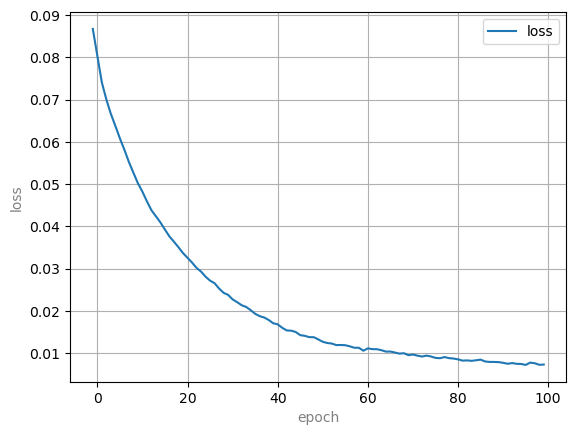

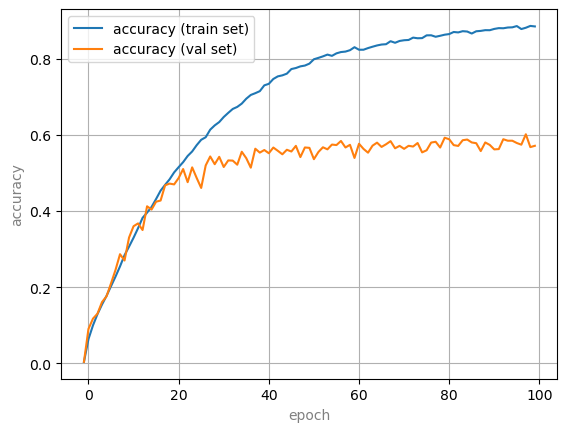

In [ ]:
plt.plot(tracing[:,0], tracing[:,1], label = 'loss')
plt.xlabel("epoch", color = 'b')
plt.ylabel("loss", color = 'y')
plt.legend()
plt.show()
plt.plot(tracing[:,0], tracing[:,2], label = 'accuracy (train set)')
plt.plot(tracing[:,0], tracing[:,3], label = 'accuracy (val set)')
plt.xlabel("epoch", color = 'b')
plt.ylabel("accuracy", color = 'y')
plt.legend()
plt.show()

##### После 100 эпох, точность на валидации превысила 0.6

In [ ]:
torch.save(my_resnet.state_dict(),'models/my_resnet18')

In [ ]:
torch.save([trainset,testset],'models/my_resnet18_datasets')

## Работа с onnx

Разбиения, на которых были обучены соответствующие модели загружаются вместе с ними.

In [ ]:
!pip install onnx
!pip install onnxruntime
!pip install onnxruntime-gpu
import torch.onnx
import onnx
import onnxruntime as ort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 60.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 5.5 MB/s eta 0:00:00


### Версия ResNet из torchvision

In [ ]:
resNet = torchvision.models.resnet18(weights = None)

num_ftrs = resNet.fc.in_features
resNet.fc = torch.nn.Linear(num_ftrs, 257)

resNet = resNet.to(device)

In [ ]:
resNet.load_state_dict(torch.load("models/torch_resnet18"))

<All keys matched successfully>

In [ ]:
_,testset = torch.load("models/torch_resnet18_datasets")

In [ ]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(resNet, torch.randn(1, 3, 224, 224, device="cuda"), "built_in_resnet.onnx", verbose=True,
                 input_names=input_names, output_names=output_names)

Exported graph: graph(%actual_input_1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(257, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(257, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_203 : Float(64, strides=[1], requires_grad=0, devi

In [ ]:
ort_session = ort.InferenceSession("built_in_resnet.onnx")

overall = 0
correct = 0

for elm in tqdm(testset):
    output = ort_session.run(None,{"actual_input_1": np.array([elm[0].numpy()],dtype = np.float32)})
    res = np.argmax(output)
    
    if(res == elm[1]):
        correct += 1
    overall += 1

accuracy = correct / overall

100%|███████████████████████████████████████| 6121/6121 [01:32<00:00, 66.25it/s]


In [ ]:
print(accuracy)

0.6033327887600065


### Имплементированная ResNet

In [ ]:
my_resnet = ResNet_18(3, 257).to(device)

In [ ]:
resNet.load_state_dict(torch.load("models/my_resnet18.60"))

In [ ]:
_, testset = torch.load("models/my_resnet18_datasets")

In [ ]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(my_resnet, torch.randn(1, 3, 224, 224, device="cuda"), "my_resnet.onnx", verbose=True,
                 input_names=input_names, output_names=output_names)

Exported graph: graph(%actual_input_1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(257, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(257, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_220 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_221 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_223 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_224 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_226 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_227 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_229 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_230 : Float(64, strides=[1], requires_grad=0, devi

In [ ]:
ort_session = ort.InferenceSession("my_resnet.onnx")

overall = 0
correct = 0

for elm in tqdm(testset):
    output = ort_session.run(None,{"actual_input_1": np.array([elm[0].numpy()],dtype = np.float32)})
    res = np.argmax(output)
    
    if(res == elm[1]):
        correct += 1
    overall += 1

accuracy = correct / overall

100%|███████████████████████████████████████| 6121/6121 [01:39<00:00, 61.57it/s]


In [ ]:
print(accuracy)

0.6038229047541251


## Вывод

В ходе выполнения этой лабораторной работы я научился с нуля обучать модели глубокого обучения. Также я ознакомился с технологией onnx. Поведение сети resNet18 из torchvision и имплементированной самостоятельно версии при обучении было идентичным. Точность моделей после сохранения в формате onnx осталась той же.